In [725]:
!which python3

/Library/Frameworks/Python.framework/Versions/3.8/bin/python3


In [727]:
pl.__version__

'1.4.2'

In [242]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from glob import glob
import random
from tqdm import tqdm
import pytorch_lightning as pl

In [2]:
with open('../data/meebits/metadata.json', 'r') as f:
    metadata = json.loads(f.read())
    f.close()

## Get Attribute Possibilities

In [3]:
image_dir = '../data/meebits/images/'
metadata_file = '../data/meebits/metadata.json'
file_type = 'png'
images = glob(os.path.join(image_dir, f'*.{file_type}'))
base_image_size = (1024,1536)

for image_file in tqdm(images):
    img = Image.open(image_file)
    assert img.size == base_image_size

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17210/17210 [00:02<00:00, 5898.89it/s]


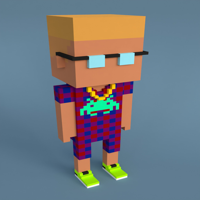

In [4]:
img.resize((200,200))

In [65]:
image_directory = image_dir
image_file_type = file_type

token_metadata = {}
idx = 0
for row in metadata:
    if row['metadata'] is not None:
        row_metadata = json.loads(row['metadata'])
        attributes = row_metadata['attributes']

        if attributes is not None:
            token_id = row['token_id']
            token_address = row['token_address']
            image_filepath = os.path.join(image_directory, f'{token_id}.{image_file_type}')
            processed_attributes = {}
            for attribute in attributes:
                processed_attributes[attribute['trait_type']] = attribute['value']
            if os.path.isfile(image_filepath):
                token_metadata[idx] = {
                    'token_id': token_id,
                    'token_address': token_address,
                    'attributes': processed_attributes,
                    'image_filepath': image_filepath
                }
                idx += 1

In [80]:
trait_pairs = {}
for nft in list(token_metadata.values()):
    for trait_type in nft['attributes']:
        if trait_type not in trait_pairs.keys():
            trait_pairs[trait_type] = []
            
        if trait_type in unique_trait_pairs.keys():
            trait_value = nft['attributes'][trait_type]
            trait_pairs[trait_type].append(trait_value)
    
# make each key/value unique
unique_trait_pairs = {}
for trait in trait_pairs:
    all_trait_values = trait_pairs[trait]
    unique_trait_values = list(set(all_trait_values))
    unique_trait_pairs[trait] = unique_trait_values

In [78]:
token_metadata[1]

{'token_id': '3641',
 'token_address': '0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7',
 'attributes': {'Type': 'Human',
  'Hair Style': 'Buzzcut',
  'Hair Color': 'Dark',
  'Hat': 'Wool Hat',
  'Hat Color': 'Black',
  'Shirt': 'Logo Tee',
  'Pants': 'Athletic Shorts',
  'Pants Color': 'Black',
  'Shoes': 'Basketball',
  'Shoes Color': 'Black',
  'Necklace': 'Gold Chain',
  'Tattoo Motif': 'BBBBLSSLBBBB,BBBBLSSLBBBB'},
 'image_filepath': '../data/meebits/images/3641.png'}

In [666]:
class MeebitDataset(torch.utils.data.Dataset):
    
    def __init__(self, image_directory: str, metadata: dict, image_file_type: str = 'png'):
        self.image_directory = image_directory
        self.image_file_type = image_file_type
        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ])
        
        import os
        token_metadata = {}
        idx = 0
        for row in metadata:
            if row['metadata'] is not None:
                row_metadata = json.loads(row['metadata'])
                attributes = row_metadata['attributes']

                if attributes is not None:
                    token_id = int(row['token_id'])
                    token_address = row['token_address']
                    image_filepath = os.path.join(self.image_directory, f'{token_id}.{self.image_file_type}')
                    processed_attributes = {}
                    for attribute in attributes:
                        processed_attributes[attribute['trait_type']] = attribute['value']
                    if os.path.isfile(image_filepath):
                        token_metadata[idx] = {
                            'token_id': token_id,
                            'token_address': token_address,
                            'attributes': processed_attributes,
                            'image_filepath': image_filepath
                        }
                        idx += 1
        
        trait_pairs = {}
        for nft in list(token_metadata.values()):
            for trait_type in nft['attributes']:
                if trait_type not in trait_pairs.keys():
                    trait_pairs[trait_type] = []

                if trait_type in trait_pairs.keys():
                    trait_value = nft['attributes'][trait_type]
                    trait_pairs[trait_type].append(trait_value)

        # make each key/value unique
        unique_trait_pairs = {}
        for trait in trait_pairs:
            all_trait_values = trait_pairs[trait]
            unique_trait_values = list(set(all_trait_values))
            unique_trait_pairs[trait] = unique_trait_values
            
        self.unique_trait_pairs = unique_trait_pairs
        
        from sklearn.preprocessing import LabelEncoder
        label_encoder_mappings = {}
        #for trait_type in self.unique_trait_pairs:
        for trait_type in trait_pairs:
            label_encoder = LabelEncoder()
            label_encoder_mappings[trait_type] = label_encoder.fit(trait_pairs[trait_type])
        
        self.label_encoder_mappings = label_encoder_mappings
        self.token_metadata = token_metadata
        #self._generate_trait_label_encoders()
        
    def __len__(self):
        return len(self.token_metadata.keys())
    
    def __getitem__(self, index):
        data = self.token_metadata[index]
        
        token_id = data['token_id']
        token_address = data['token_address']
        attributes = data['attributes']
        image_filepath = data['image_filepath']
        
        image = Image.open(image_filepath)
        image = self.transforms(image)
        encoded_attributes = self._encode_attributes(attributes)
        
        return token_id, encoded_attributes, image
    
    def _generate_trait_label_encoders(self):
        
        all_trait_types = {}
        for nft in self.token_metadata:
            for trait_type in self.token_metadata[nft]['attributes']:
                trait_value = self.token_metadata[nft]['attributes'][trait_type]

                if trait_type in all_trait_types.keys():
                    all_trait_types[trait_type].append(trait_value)
                else:
                    all_trait_types[trait_type] = []
                    
                    
        from sklearn.preprocessing import LabelEncoder
        label_encoder_mappings = {}
        for trait_type in all_trait_types:
            label_encoder = LabelEncoder()
            label_encoder_mappings[trait_type] = label_encoder.fit(all_trait_types[trait_type])
        
        self.all_trait_types = all_trait_types
        self.label_encoder_mappings = label_encoder_mappings
        
    def _encode_attributes(self, attributes):
        encoded_attributes = []
        for trait in self.label_encoder_mappings.keys():
            value = np.array([-1])
            if trait in attributes.keys():
                label_encoder = self.label_encoder_mappings[trait]
                try:
                    value = label_encoder.transform([attributes[trait]])
                except Exception as e:
                    pass
                                
            encoded_attributes.append(float(value))
        
        encoded_attributes = torch.tensor(encoded_attributes).view(-1)
        assert encoded_attributes.shape == torch.Size([21]), f'encoded_attributes.shape: {encoded_attributes.shape}'
        return encoded_attributes

In [667]:
dataset = MeebitDataset(image_dir, metadata, file_type)
dataset[0]

(10175,
 tensor([ 2.,  4.,  6.,  4.,  7., 21.,  1.,  7.,  4.,  3., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1.]),
 tensor([[[0.3843, 0.3804, 0.3804,  ..., 0.3765, 0.3765, 0.3725],
          [0.3804, 0.3804, 0.3765,  ..., 0.3765, 0.3765, 0.3725],
          [0.3765, 0.3765, 0.3765,  ..., 0.3765, 0.3765, 0.3725],
          ...,
          [0.3686, 0.3686, 0.3686,  ..., 0.3725, 0.3765, 0.3765],
          [0.3725, 0.3725, 0.3725,  ..., 0.3765, 0.3765, 0.3765],
          [0.3725, 0.3725, 0.3725,  ..., 0.3725, 0.3725, 0.3725]],
 
         [[0.4902, 0.4863, 0.4863,  ..., 0.4824, 0.4824, 0.4784],
          [0.4863, 0.4863, 0.4824,  ..., 0.4824, 0.4824, 0.4784],
          [0.4824, 0.4824, 0.4824,  ..., 0.4824, 0.4824, 0.4784],
          ...,
          [0.4784, 0.4784, 0.4784,  ..., 0.4863, 0.4824, 0.4824],
          [0.4824, 0.4824, 0.4863,  ..., 0.4824, 0.4824, 0.4824],
          [0.4824, 0.4824, 0.4863,  ..., 0.4784, 0.4784, 0.4784]],
 
         [[0.5725, 0.5686, 0.5686,  ...

In [668]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

In [669]:
idx, t = next(enumerate(dataloader))

In [670]:
class MeebitDataLoader(pl.LightningDataModule):
    
    def __init__(
        self, 
        image_directory: str, 
        metadata: dict, 
        batch_size: int = 4,
        image_file_type: str = 'png', 
        train_size: float = 0.75, 
        test_size: float = 0.15, 
    ):
        super().__init__()
        
        self.image_directory = image_directory
        self.metadata = metadata
        self.batch_size = batch_size
        self.image_file_type = image_file_type
        self.train_size = train_size
        self.test_size = test_size
        
    def setup(self):
        dataset = MeebitDataset(self.image_directory, self.metadata, self.image_file_type)
        number_of_rows = len(dataset)
        train_samples = int(number_of_rows * self.train_size)
        test_samples = int(number_of_rows * self.test_size)
        val_samples = number_of_rows - train_samples - test_samples
        self.train, self.test, self.val = torch.utils.data.random_split(
            dataset, 
            (train_samples, test_samples, val_samples)
        )
        
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val, 
            batch_size=self.batch_size,
            shuffle=True
        )
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test, 
            batch_size=self.batch_size,
            shuffle=False
        )

In [671]:
dataloader = MeebitDataLoader(image_dir, metadata)
dataloader.setup()

In [672]:
idx, (token_id, attribute, image) = next(enumerate(dataloader.train_dataloader()))

In [673]:
attribute.shape

torch.Size([4, 21])

In [740]:
class NFTReverseEngineer(pl.LightningModule):
    def __init__(self, learning_rate: float = 1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        
        self.loss = nn.MSELoss()
        
        self.linear = nn.Linear(1024, 1024)
        
        self.width_conv1 = nn.Conv1d(21, 512, kernel_size=1)
        self.width_conv2 = nn.Conv1d(512, 1024, kernel_size=1)
        self.width_batch_norm1 = nn.BatchNorm1d(512)
        self.width_batch_norm2 = nn.BatchNorm1d(1024)
        
        self.height_conv1 = nn.Conv1d(1, 256, kernel_size=1)
        self.height_conv2 = nn.Conv1d(256, 512, kernel_size=1)
        self.height_conv3 = nn.Conv1d(512, 1536, kernel_size=1)
        self.height_batch_norm1 = nn.BatchNorm1d(256)
        self.height_batch_norm2 = nn.BatchNorm1d(512)
        self.height_batch_norm3 = nn.BatchNorm1d(1536)
        
        self.channel_conv = nn.Conv2d(1, 3, kernel_size=1)
        self.channel_batch_norm = nn.BatchNorm2d(3)
    
    def forward(self, x):
        
        x = x.unsqueeze(-1)
        x = self.width_conv1(x)
        x = self.width_batch_norm1(x)
        x = self.width_conv2(x)
        x = self.width_batch_norm2(x)

        x = x.view(-1, 1, x.shape[1])
        x = self.height_conv1(x)
        x = self.height_batch_norm1(x)
        x = self.height_conv2(x)
        x = self.height_batch_norm2(x)
        x = self.height_conv3(x)
        x = self.height_batch_norm3(x)
        
        x = x.view(-1, 1, x.shape[1], x.shape[2])
        x = self.channel_conv(x)
        x = self.channel_batch_norm(x)
        
        x = self.linear(x)
        
        return x
    
    def _step(self, batch):
        token_id, attribute, image = batch
        prediction = self(attribute)        
        loss = self.loss(prediction, image)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._step(batch)
    
    def validation_step(self, batch, batch_idx):
        return self._step(batch)
    
    def test_step(self, batch, batch_idx):
        return self._step(batch)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.learning_rate
        )
        return optimizer

model = NFTReverseEngineer()

In [741]:
trainer = pl.Trainer(default_root_dir='../', fast_dev_run=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).


In [742]:
trainer.fit(model, dataloader)


   | Name               | Type        | Params
----------------------------------------------------
0  | loss               | MSELoss     | 0     
1  | linear             | Linear      | 1.0 M 
2  | width_conv1        | Conv1d      | 11.3 K
3  | width_conv2        | Conv1d      | 525 K 
4  | width_batch_norm1  | BatchNorm1d | 1.0 K 
5  | width_batch_norm2  | BatchNorm1d | 2.0 K 
6  | height_conv1       | Conv1d      | 512   
7  | height_conv2       | Conv1d      | 131 K 
8  | height_conv3       | Conv1d      | 787 K 
9  | height_batch_norm1 | BatchNorm1d | 512   
10 | height_batch_norm2 | BatchNorm1d | 1.0 K 
11 | height_batch_norm3 | BatchNorm1d | 3.1 K 
12 | channel_conv       | Conv2d      | 6     
13 | channel_batch_norm | BatchNorm2d | 6     
----------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.056    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

torch.Size([4, 3, 1536, 1024])


Validating: 0it [00:00, ?it/s]

torch.Size([4, 3, 1536, 1024])


/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
